(still in progress)
here I'm using a UNet with a pre-trained backbone

Loading numpy arrays with patches from Amsterdam, Dublin, Ghent, Manchester, Seattle and San Francisco. This patches have 3 bands - ndvi, landcover, ndbi. They were also filtered to have only patches that have at least 10% of parks. Based on them model is build - Unet with Resnet50 backbone

In [ ]:
#install packages
!pip install patchify
!pip install segmentation_models

In [ ]:
import os
import numpy as np

In [ ]:
# Connecting to the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


get the data from drive

In [ ]:
#Amsterdam
image_array_amsterdam = np.load('location of Amsterdam image balanced chips')
park_array_amsterdam = np.load('location of Amsterdam park balanced chips')

In [ ]:
#dublin
image_array_dublin = np.load('location of Dublin image balanced chips')
park_array_dublin = np.load('location of Dublin park balanced chips')

In [ ]:
#ghent
image_array_ghent = np.load('location of Ghent image balanced chips')
park_array_ghent = np.load('location of Ghent park balanced chips')

In [ ]:
#Manchester
image_array_manchester = np.load('location of Manchester image balanced chips')
park_array_manchester = np.load('location of Manchester park balanced chips')

In [ ]:
#san francisco data
image_array_san_francisco = np.load('location of San Francisco image balanced chips')
park_array_san_francisco = np.load('location of San Francisco park balanced chips')

In [ ]:
#seattle data
image_array_seattle = np.load('location of Seattle image balanced chips')
park_array_seattle = np.load('location of Seattle park balanced chips')

In [ ]:
print(image_array_amsterdam.shape)
print(image_array_dublin.shape)
print(image_array_ghent.shape)
print(image_array_manchester.shape)
print(image_array_san_francisco.shape)
print(image_array_seattle.shape)

(723, 256, 256, 3)
(710, 256, 256, 3)
(434, 256, 256, 3)
(955, 256, 256, 3)
(706, 256, 256, 3)
(813, 256, 256, 3)


merge into one numpy array

In [ ]:
#merge into one numpy array
image_dataset = np.concatenate((image_array_amsterdam, image_array_dublin,  image_array_manchester, image_array_san_francisco, image_array_ghent,
                                image_array_seattle), axis=0)
park_dataset = np.concatenate((park_array_amsterdam, park_array_dublin,  park_array_manchester, park_array_san_francisco, park_array_ghent,
                                park_array_seattle), axis=0)

In [ ]:
del image_array_amsterdam, image_array_dublin,  image_array_manchester, image_array_san_francisco, image_array_seattle , image_array_ghent,
del park_array_amsterdam, park_array_dublin,  park_array_manchester, park_array_san_francisco, park_array_seattle, park_array_ghent,

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

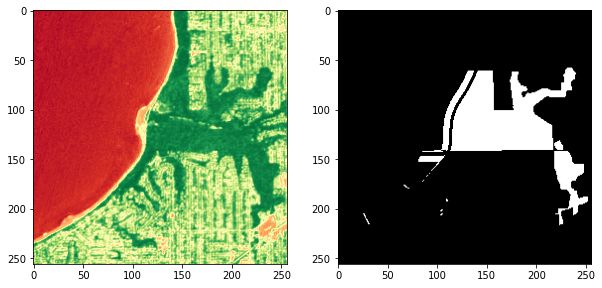

In [ ]:
# check whether the cropped images match

# generate random number
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(image_dataset[image_number,:,:,0], cmap='RdYlGn')

# plot parks - white is park
plt.subplot(122)
plt.imshow(park_dataset[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
image_dataset[image_dataset > 1] = 1  # replace some wired values like 1.000001 with 1
print("Image data shape is: ", image_dataset.shape)
print("Park data shape is: ", park_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Min pixel value in image is: ", image_dataset.min())
print("Labels in the mask are : ", np.unique(park_dataset))
print("Number of park pixels: ", np.count_nonzero(park_dataset == 1))
print("Number of no-park pixels: ", np.count_nonzero(park_dataset == 0))
print("Percentage of park: ", np.count_nonzero(park_dataset == 1)/(np.count_nonzero(park_dataset == 1)+np.count_nonzero(park_dataset == 0)))

Image data shape is:  (4341, 256, 256, 3)
Park data shape is:  (4341, 256, 256, 1)
Max pixel value in image is:  1.0
Min pixel value in image is:  0.0
Labels in the mask are :  [0. 1.]
Number of park pixels:  57402947
Number of no-park pixels:  227088829
Percentage of park:  0.2017736604097828


prepering data for modelling

In [ ]:
from sklearn.model_selection import train_test_split
X_train_old, X_test_old, y_train, y_test = train_test_split(image_dataset, park_dataset, 
                                                    test_size = 0.2, random_state = 42) #changed the learning to 0.8 if more data

In [ ]:
import cv2
import numpy as np

In [ ]:
X_train_old.shape

(3472, 256, 256, 3)

In [ ]:
y_train.shape

(3472, 256, 256, 1)

model building with a backbone

In [ ]:
# preprocess input to fit model architecture
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import keras
import tensorflow
from keras.layers import Input, Conv2D
from keras.models import Model

BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE) # get the preprocessing function
X_train = preprocess_input(X_train_old)
X_test = preprocess_input(X_test_old)
print(X_train.shape, X_test.shape)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
(3472, 256, 256, 3) (869, 256, 256, 3)


In [ ]:
# turn park_dataset into categorical
from tensorflow.keras.utils import to_categorical

# y_train
train_masks_cat = to_categorical(y_train, num_classes=2)
y_train = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 2))

# y_test
test_masks_cat = to_categorical(y_test, num_classes=2)
y_test = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], 2))

print(y_train.shape, y_test.shape)

(3472, 256, 256, 2) (869, 256, 256, 2)


data augumentation

In [ ]:
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90, width_shift_range=0.3, height_shift_range=0.3, shear_range=0.5, 
                         zoom_range=0.3, horizontal_flip=True, vertical_flip=True, fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90, width_shift_range=0.3, height_shift_range=0.3, shear_range=0.5, 
                         zoom_range=0.3, horizontal_flip=True, vertical_flip=True, fill_mode='reflect',
                         preprocessing_function = lambda x: np.where(x > 0, 1, 0).astype(x.dtype)) 

In [ ]:
# set the batch size of image generator
batch_size= 8

# image generator (X_train and X_test)
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) 

# mask generator (y_train and y_test)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3472, 256, 256, 2) (2 channels).
  ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3472, 256, 256, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 chann

In [ ]:
# put image generator and mask generator together
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_generator = my_image_mask_generator(image_generator, mask_generator)
validation_generator = my_image_mask_generator(valid_img_generator, valid_mask_generator)

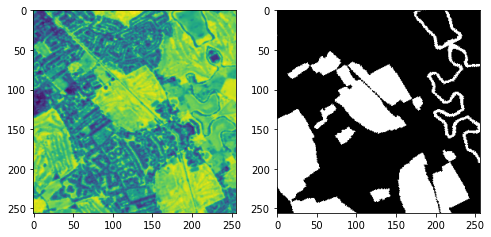

In [ ]:
#check the augumentation 
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    plt.figure(figsize=(8, 4))
    image = x[i]
    mask = y[i]
    plt.subplot(121)
    plt.imshow(image[:,:,0])
    
    plt.subplot(122)
    plt.imshow(mask[:,:,1], cmap = 'gray')
    plt.show()

model set up 

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
# build model (U-Net with resnet34 backbone, pretrained on imagenet)
sm.set_framework('tf.keras')
sm.framework()


#define model
model = sm.Unet(backbone_name = 'resnet50', encoder_weights='imagenet', classes= 2, activation = 'sigmoid') 

# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer=Adam(learning_rate = 1e-4), loss = sm.losses.binary_focal_dice_loss, 
               metrics=['accuracy', sm.metrics.IOUScore(threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

#loss = sm.losses.binary_focal_loss,
# #model.summary()

94601216/94592056 [==============================] - 1s 0us/step


In [ ]:
# set hyperparameters - data augumentation
batch_size = 16
steps_per_epoch = len(X_train)//batch_size  # for generator, you need to specify the steps if using generator
validation_steps = len(X_test)//batch_size  # for generator
print(steps_per_epoch, validation_steps)

217 54


In [ ]:
# model training (with data augmentation)
history = model.fit(train_generator, batch_size=16, epochs=50,  steps_per_epoch = steps_per_epoch,
                     validation_steps = validation_steps, verbose=1, validation_data = validation_generator)

Epoch 1/50
217/217 [==============================] - 68s 225ms/step - loss: 0.4985 - accuracy: 0.7876 - iou_score: 0.6049 - precision: 0.7496 - recall: 0.8604 - val_loss: 0.6987 - val_accuracy: 0.3692 - val_iou_score: 0.3210 - val_precision: 0.4439 - val_recall: 0.5441
Epoch 2/50
217/217 [==============================] - 48s 221ms/step - loss: 0.3807 - accuracy: 0.8578 - iou_score: 0.6733 - precision: 0.8255 - recall: 0.8953 - val_loss: 0.6725 - val_accuracy: 0.4445 - val_iou_score: 0.3315 - val_precision: 0.4831 - val_recall: 0.5363
Epoch 3/50
217/217 [==============================] - 47s 217ms/step - loss: 0.3281 - accuracy: 0.8838 - iou_score: 0.7083 - precision: 0.8772 - recall: 0.8905 - val_loss: 0.7726 - val_accuracy: 0.5784 - val_iou_score: 0.4019 - val_precision: 0.5932 - val_recall: 0.6083
Epoch 4/50
217/217 [==============================] - 47s 218ms/step - loss: 0.2987 - accuracy: 0.8913 - iou_score: 0.7203 - precision: 0.8923 - recall: 0.8883 - val_loss: 0.4291 - val_ac

In [ ]:
#save model

from tensorflow import keras
model.save('location to save the model') #save model to drive

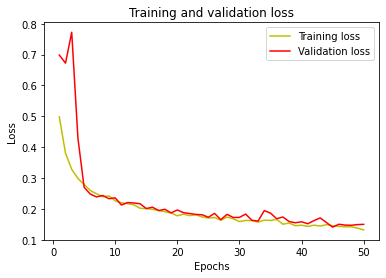

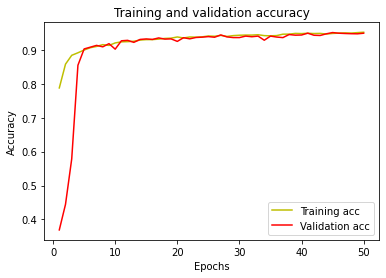

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Metrics 'accuracy', sm.metrics.IOUScore(threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
loss, acc, IoU, precision, recall = model.evaluate(X_test, y_test, verbose = 0)

print("Loss is ", loss)
print("Accuracy is ", acc)
print("IoU is ", IoU)
print("Precision is", precision)
print("Recall is", recall)

Loss is  0.12187198549509048
Accuracy is  0.9579126238822937
IoU is  0.8786126375198364
Precision is 0.9526038765907288
Recall is 0.9623613953590393


In [ ]:
#how many pixels are predicted to be parks
y_pred=model.predict(X_test)
y_pred.mean()

0.5008636

plot ground truth + predicted

(256, 256)


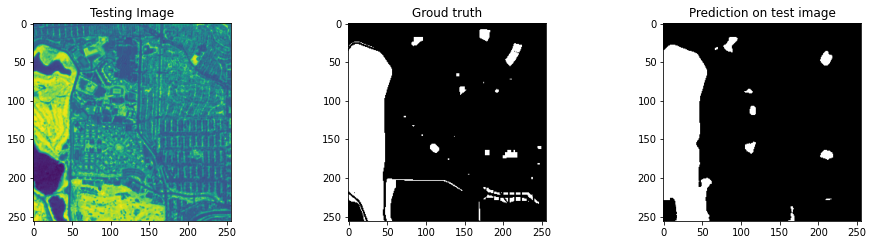

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input(test_img_input)

test_pred1 = model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

print(test_prediction1.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])

plt.subplot(232)
plt.title('Groud truth')
plt.imshow(ground_truth[:,:,1], cmap='gray')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')

plt.show()

test on Philedelphia in different script